## Part 5

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%
print(Xtr)

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])
tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5,  2],
        ...,
        [25,  1, 14],
        [ 1, 14, 14],
        [14, 14,  9]])


In [6]:

# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
    # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
    # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
    # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
  
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
  
    def parameters(self):
        return []

class Sequential:
  
    def __init__(self, layers):
        self.layers = layers
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
    # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]


In [7]:
torch.manual_seed(42);

In [8]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP



model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),

])
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident so we are not confidently wrong at initialization
  model.layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [9]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
#     with torch.no_grad():
#         ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])



#     if i >= 1000:
#         break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3006
  10000/ 200000: 2.3788
  20000/ 200000: 2.4801
  30000/ 200000: 2.3083
  40000/ 200000: 2.0163
  50000/ 200000: 2.5618
  60000/ 200000: 2.5307
  70000/ 200000: 1.8858
  80000/ 200000: 1.8750
  90000/ 200000: 1.6711
 100000/ 200000: 2.2941
 110000/ 200000: 2.2802
 120000/ 200000: 2.2242
 130000/ 200000: 2.0855
 140000/ 200000: 2.4169
 150000/ 200000: 2.0249
 160000/ 200000: 1.9504
 170000/ 200000: 2.2795
 180000/ 200000: 2.1730
 190000/ 200000: 1.9756


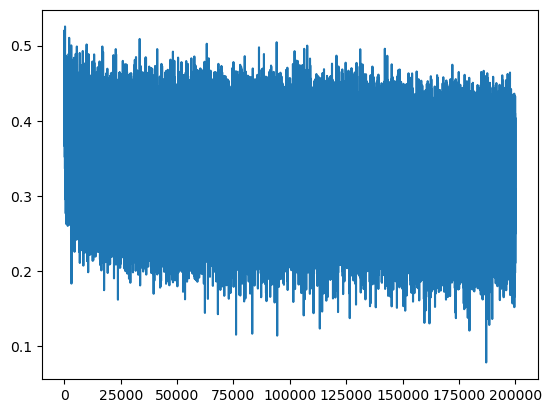

In [10]:
plt.plot(lossi)

### Note:
- This loss is hard to visualize. 
- Here we are using view as it is cheap in terms of memory in pytorch.

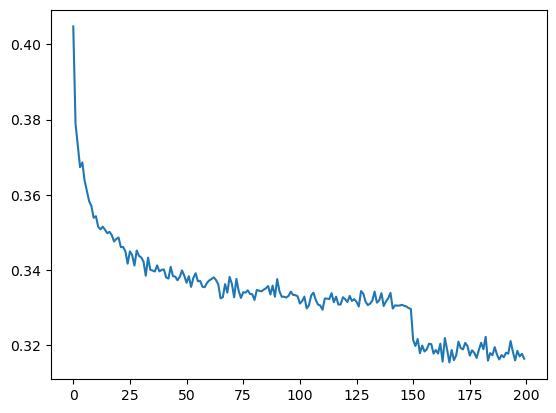

In [11]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

### Note:
- The sudden drop is corresponding to the learning rate decay. 

In [12]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [13]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

# put layers into eval mode
for layer in model.layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 2.0589985847473145
val 2.1079225540161133


### Note:
- Becasue the train and val loss are similar to each other, we are not overfitting too much so we can get additional performance by scalling the size of the neural network by making it bigger and deeper.

In [14]:
# sample from the model

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
      # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
      # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

ivon.
fadili.
thio.
masa.
kelz.
matyn.
leandr.
aleigh.
kolariiah.
prus.
carleen.
jir.
joan.
galoni.
shina.
kaisandraasia.
juna.
vio.
olven.
meriell.


### Notes:
- With current architecture it will not be efficient to scale the network.
- All the characters are currently crushed to in a single layer. 
- In wavenet, the characters are crushed slowly, we take two characters and fuse them in sort of a bigram representation, 
- We then take these bigrams and slowly fuse them again, we do that in a tree like hierarchical manner. 

# Wavenet

In [15]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182437, 8]) torch.Size([182437])
torch.Size([22781, 8]) torch.Size([22781])
torch.Size([22928, 8]) torch.Size([22928])


In [16]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> t
.......t --> a
......ta --> u
.....tau --> r
....taur --> e
...taure --> n
..tauren --> .
........ --> s
.......s --> u
......su --> l
.....sul --> e
....sule --> m
...sulem --> a
..sulema --> n
.suleman --> .
........ --> z
.......z --> e
......ze --> r
.....zer --> e
....zere --> n


In [17]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP



model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),

])
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident so we are not confidently wrong at initialization
  model.layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22097


In [25]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
#     with torch.no_grad():
#         ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])



#     if i >= 1000:
#         break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2849
  10000/ 200000: 2.4329
  20000/ 200000: 2.2375
  30000/ 200000: 2.3655
  40000/ 200000: 2.3272
  50000/ 200000: 1.8463
  60000/ 200000: 1.8778
  70000/ 200000: 1.9540
  80000/ 200000: 1.9137
  90000/ 200000: 1.9069
 100000/ 200000: 2.1002
 110000/ 200000: 2.1621
 120000/ 200000: 1.7335
 130000/ 200000: 1.7590
 140000/ 200000: 1.7110
 150000/ 200000: 2.1679
 160000/ 200000: 1.7414
 170000/ 200000: 1.9214
 180000/ 200000: 1.9094
 190000/ 200000: 1.9989


### Note:
- Watch the lecture understand how FlattenConsecutive is implemented.
- The Batchnorm is also modified as we are now not getting 2 dimentional input. 

In [26]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
    # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
    # calculate the forward pass
        if self.training:
            if x.dim == 2:
                dim = 0
            elif x.dim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
    # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
  
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
  
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
  
    def parameters(self):
        return []

class Sequential:
  
    def __init__(self, layers):
        self.layers = layers
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
    # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]


In [27]:
torch.manual_seed(42);

### Note:
- Here we are changing the n_hidden such that the total number of parameters are same as before. 
- (This was tried, but later we increase the parameters) As we have the same number of parameters, the network has the same capacity, we are changing the architecture to make it more efficient (wavenet).

In [34]:
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP



model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),

])
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident so we are not confidently wrong at initialization
  model.layers[-1].weight *= 0.1


parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

76579


In [35]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
#     with torch.no_grad():
#         ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])



#     if i >= 1000:
#         break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2972
  10000/ 200000: 2.3217
  20000/ 200000: 2.4566
  30000/ 200000: 1.8652
  40000/ 200000: 2.3373
  50000/ 200000: 2.4779
  60000/ 200000: 1.9003
  70000/ 200000: 2.3628
  80000/ 200000: 1.7906
  90000/ 200000: 1.9576
 100000/ 200000: 1.8537
 110000/ 200000: 1.8998
 120000/ 200000: 2.3251
 130000/ 200000: 2.2302
 140000/ 200000: 2.2375
 150000/ 200000: 1.7638
 160000/ 200000: 1.7309
 170000/ 200000: 1.6598
 180000/ 200000: 1.5734
 190000/ 200000: 1.4422


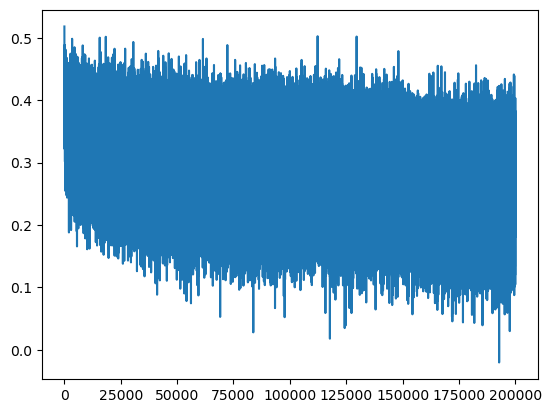

In [36]:
plt.plot(lossi)

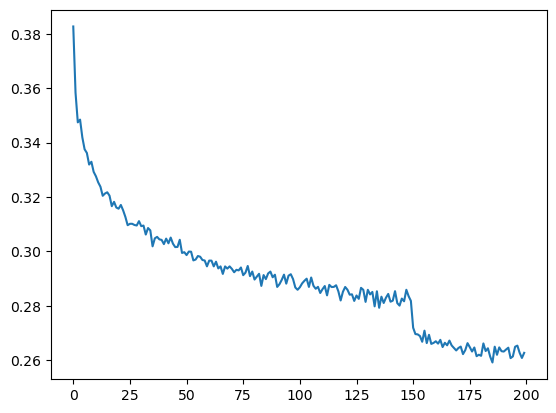

In [37]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [38]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [39]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
        }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

# put layers into eval mode
for layer in model.layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 1.8044298887252808
val 1.9919583797454834


### Why convolutions:
- Allows efficient forward pass as that is implemented using Kenels in CUDA.